# Praca domowa 6

In [144]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8,8]
import numpy as np
import pandas as pd
import seaborn as sns
import cv2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_olivetti_faces

## Wczytanie danych

In [145]:
data = fetch_olivetti_faces(return_X_y=False, shuffle=True, random_state=42)

In [146]:
print(data.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [147]:
X = data.data
X.shape

(400, 4096)

In [148]:
def reshape(X):
    return X.reshape(X.shape[0], 64, 64)

In [149]:
X_train = X[:340, ]
X_test = X[340:400, ]

sd_scaler = StandardScaler()
sd_scaler.fit(X_train)
X_train = sd_scaler.transform(X_train)
X_test = sd_scaler.transform(X_test)

In [150]:
def plot_faces(data, n_faces=4):
    _, axes = plt.subplots(nrows=1, ncols=n_faces, figsize=(10, 3))
    for ax, image in zip(axes, data):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray)

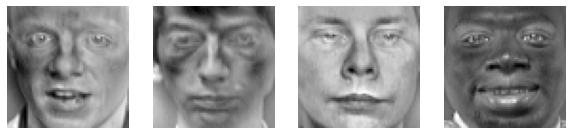

In [151]:
plot_faces(reshape(X_train))

## Kompresja

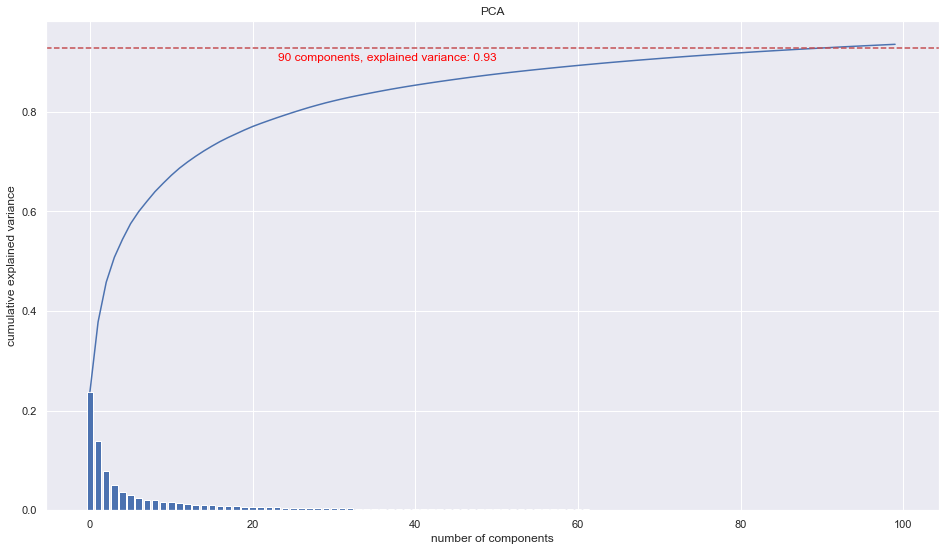

In [152]:
pca = PCA(random_state=1)
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
n = 100
m = 90
m_comp_explained_variance = np.sum(explained_variance[0:m+1])

plt.rcParams["figure.figsize"] = [16,9]
plt.plot(np.cumsum(explained_variance[0:n]))
plt.bar(np.arange(n), explained_variance[0:n])
plt.axhline(y=m_comp_explained_variance, color="r", linestyle="dashed")
plt.text(50,m_comp_explained_variance-0.02, 
         str(m) + " components, explained variance: " + "{:.2f}".format(m_comp_explained_variance), 
         color="red", 
        ha="right", va="center")
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance");
plt.title("PCA")
plt.show()

In [153]:
pca = PCA(n_components = 90, random_state=1)
pca.fit(X_train)
X_pca = pca.transform(X_train)
X_hat = pca.inverse_transform(X_pca)

In [163]:
print(f"Compress ratio: {4096/90:.2f}")

Compress ratio: 45.51


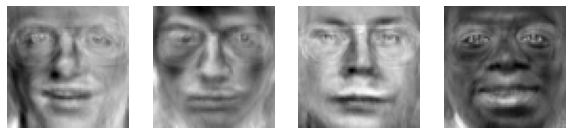

In [154]:
plot_faces(reshape(X_hat))
# 90 komponentów PCA dają znaczący stopień kompresji
# i można z nich odrestaurować obrazy o akceptowalnej jakości

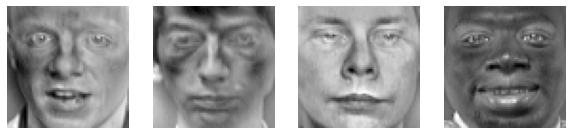

In [155]:
plot_faces(reshape(X_train))

In [132]:
def get_errors(X, X_hat):
    errors = np.zeros(X.shape[0])
    for i in range(len(errors)):
        errors[i] = mean_squared_error(X[i], X_hat[i], squared=False)
    return errors

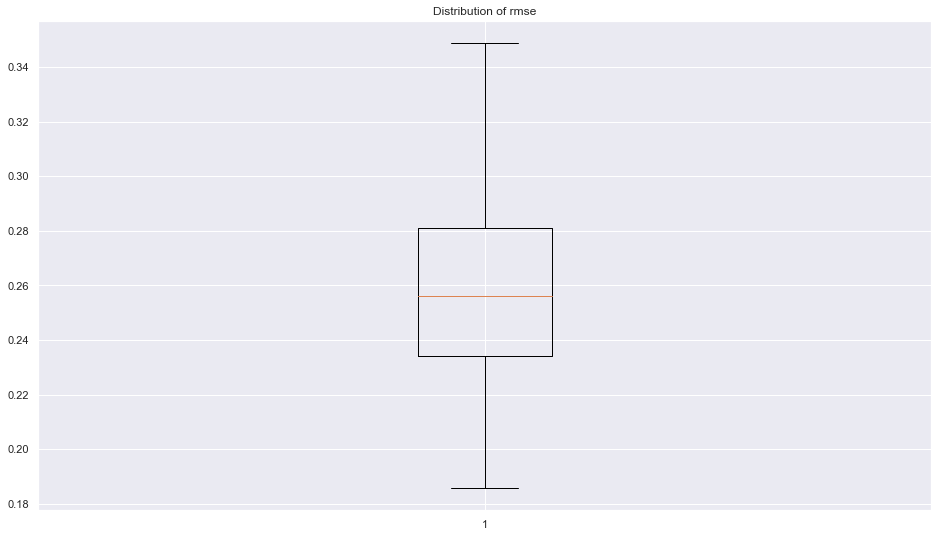

In [156]:
plt.boxplot(get_errors(X_train, X_hat))
plt.title("Distribution of rmse")
plt.show()

## Zmodyfikowane obrazy

In [157]:
kernel = np.ones((5,5),np.float32)/25

modifications = [
    lambda x: cv2.rotate(x.reshape((64, 64)), cv2.ROTATE_90_CLOCKWISE), # obrót
    lambda x: cv2.flip(x.reshape((64, 64)), -1), # odbicie
    lambda x: cv2.filter2D(x.reshape((64, 64)), -1, kernel) # rozmycie
]
modifications_names = [
    "rotation",
    "flip",
    "blur"
]

In [158]:
X_test_modified = np.empty((60, 4096))
labels = [""] * 60
for i in range(60):
    X_test_modified[i] = modifications[i%3](X_test[i]).reshape(4096)
    labels[i] = modifications_names[i%3]

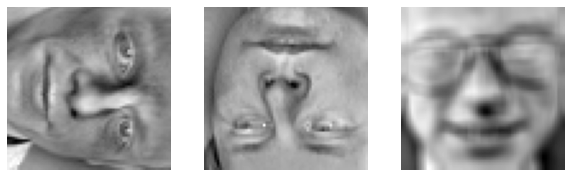

In [159]:
plot_faces(reshape(X_test_modified), 3)

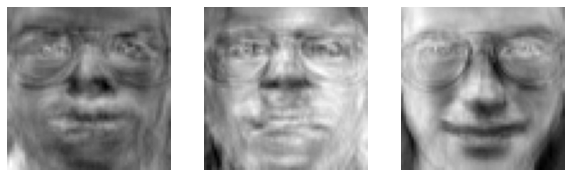

In [160]:
X_test_modified_pca = pca.transform(X_test_modified)
X_test_modified_hat = pca.inverse_transform(X_test_modified_pca)

plot_faces(reshape(X_test_modified_hat), 3)
# jak można było się spodziewać, w miarę dobry wynik wyszedł tylko przy rozmyciu

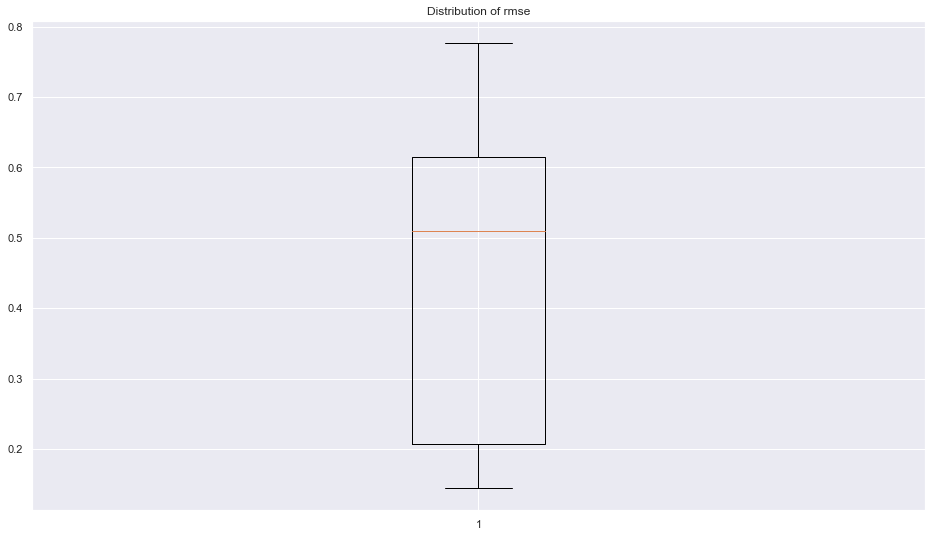

In [161]:
plt.boxplot(get_errors(X_test_modified, X_test_modified_hat))
plt.title("Distribution of rmse")
plt.show()
# oczywiście mediana błędu wzrosła
# dzieje się tak najdpawdopodobniej przez obroty i odbicia

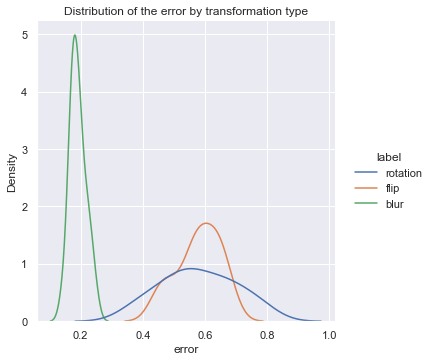

In [104]:
errors = get_errors(X_test_modified, X_test_modified_hat)
error_data = pd.DataFrame.from_dict({
    "error": errors,
    "label": labels
})

sns.displot(error_data, x="error", hue="label", kind="kde")
plt.title("Distribution of the error by transformation type")
plt.show()
# skoro transformacje były różnej "trudności", zobaczmy jak wygląda rozkład błędu
# dla każdej transformacji oddzielnie
# wykres potwierdza powyższe spostrzeżenia

## Podsumowanie
Jak widać z powyższych eksperymentów, PCA nadaje się do wykrywania np. obrotów lub odbić(bo daje wtedy duży rmse). Rozmycie z kolei dużego błędu nie daje.